In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
# -----------------------------
# Config
# -----------------------------
DATA_DIR = "/kaggle/input/pneumonia-imbalance-chest-x-ray-dataset"
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 4
VAL_SPLIT = 0.1
SEED = 42

# -----------------------------
# Base transform (no normalize)
# -----------------------------
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# -----------------------------
# Load full training set (stats + split)
# -----------------------------
full_train_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/train",
    transform=base_transform
)
# -----------------------------
# Compute mean & std (optimal + tqdm)
# -----------------------------
def compute_mean_std(dataset):
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

    channel_sum = torch.zeros(3)
    channel_sum_sq = torch.zeros(3)
    n_pixels = 0

    for images, _ in tqdm(loader, desc="Computing mean/std", unit="batch"):
        b, c, h, w = images.shape
        pixels = b * h * w

        channel_sum += images.sum(dim=[0, 2, 3])
        channel_sum_sq += (images ** 2).sum(dim=[0, 2, 3])
        n_pixels += pixels

    mean = channel_sum / n_pixels
    std = (channel_sum_sq / n_pixels - mean ** 2).sqrt()
    return mean, std

mean, std = compute_mean_std(full_train_dataset)
# -----------------------------
# Final transform (shared everywhere)
# -----------------------------
final_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# -----------------------------
# Rebuild datasets with final transforms
# -----------------------------
full_train_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/train",
    transform=final_transform
)

test_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/test",
    transform=final_transform
)

# -----------------------------
# Train / Validation split
# -----------------------------
val_size = int(len(full_train_dataset) * VAL_SPLIT)
train_size = len(full_train_dataset) - val_size

generator = torch.Generator().manual_seed(SEED)

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=generator
)

# Validation must not use augmentation
val_dataset.dataset.transform = final_transform
# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# -----------------------------
# Sanity checks
# -----------------------------
print("Classes:", full_train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Computing mean/std: 100%|██████████| 2157/2157 [00:51<00:00, 42.21batch/s]


Classes: ['Bacterial Pneumonia', 'COVID', 'Lung_Opacity', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Train samples: 15526
Val samples: 1725
Test samples: 4929


In [4]:
!pip install torchinfo timm
!pip install --quiet torchview graphviz

In [5]:
image_size = 256           # Standard starting resolution
num_classes = 6            # Four-class classification task
import timm
model = timm.create_model('swinv2_tiny_window8_256', pretrained=True, num_classes=num_classes)

summary(model, input_size=(1, 3, 256, 256),
        col_names=["input_size", "output_size", "num_params", "trainable"])

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SwinTransformerV2                                  [1, 3, 256, 256]          [1, 6]                    --                        True
├─PatchEmbed: 1-1                                  [1, 3, 256, 256]          [1, 64, 64, 96]           --                        True
│    └─Conv2d: 2-1                                 [1, 3, 256, 256]          [1, 96, 64, 64]           4,704                     True
│    └─LayerNorm: 2-2                              [1, 64, 64, 96]           [1, 64, 64, 96]           192                       True
├─Sequential: 1-2                                  [1, 64, 64, 96]           [1, 8, 8, 768]            --                        True
│    └─SwinTransformerV2Stage: 2-3                 [1, 64, 64, 96]           [1, 64, 64, 96]           --                        True
│    │    └─Identity: 3-1                          [1, 64

In [6]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [7]:
# Hyperparameters
num_epochs       = 25
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [8]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.3519, accuracy: 0.8736, precision: 0.8730, recall: 0.8736, f1_score: 0.8727, specificity: 0.9116, sensitivity: 0.9851, mcc: 0.8263, auc: 0.9689


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.13it/s]


Metrics - loss: 0.2066, accuracy: 0.9241, precision: 0.9277, recall: 0.9241, f1_score: 0.9241, specificity: 0.8860, sensitivity: 1.0000, mcc: 0.8960, auc: 0.9902


Training Model - Epoch [2/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.48it/s]


Metrics - loss: 0.1836, accuracy: 0.9385, precision: 0.9384, recall: 0.9385, f1_score: 0.9383, specificity: 0.9624, sensitivity: 0.9950, mcc: 0.9158, auc: 0.9893


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.06it/s]


Metrics - loss: 0.1411, accuracy: 0.9530, precision: 0.9530, recall: 0.9530, f1_score: 0.9529, specificity: 0.9948, sensitivity: 1.0000, mcc: 0.9356, auc: 0.9933


Training Model - Epoch [3/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.50it/s]


Metrics - loss: 0.1449, accuracy: 0.9498, precision: 0.9498, recall: 0.9498, f1_score: 0.9497, specificity: 0.9783, sensitivity: 0.9970, mcc: 0.9313, auc: 0.9930


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.05it/s]


Metrics - loss: 0.1776, accuracy: 0.9426, precision: 0.9431, recall: 0.9426, f1_score: 0.9424, specificity: 0.9845, sensitivity: 0.9987, mcc: 0.9212, auc: 0.9935


Training Model - Epoch [4/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.49it/s]


Metrics - loss: 0.1125, accuracy: 0.9616, precision: 0.9616, recall: 0.9616, f1_score: 0.9616, specificity: 0.9829, sensitivity: 0.9981, mcc: 0.9475, auc: 0.9948


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.02it/s]


Metrics - loss: 0.1778, accuracy: 0.9443, precision: 0.9444, recall: 0.9443, f1_score: 0.9443, specificity: 1.0000, sensitivity: 0.9980, mcc: 0.9235, auc: 0.9940


Training Model - Epoch [5/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.50it/s]


Metrics - loss: 0.0968, accuracy: 0.9681, precision: 0.9681, recall: 0.9681, f1_score: 0.9681, specificity: 0.9823, sensitivity: 0.9983, mcc: 0.9564, auc: 0.9962


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.22it/s]


Metrics - loss: 0.2340, accuracy: 0.9142, precision: 0.9241, recall: 0.9142, f1_score: 0.9158, specificity: 0.8394, sensitivity: 1.0000, mcc: 0.8846, auc: 0.9941


Training Model - Epoch [6/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.50it/s]


Metrics - loss: 0.0751, accuracy: 0.9753, precision: 0.9753, recall: 0.9753, f1_score: 0.9753, specificity: 0.9897, sensitivity: 0.9988, mcc: 0.9663, auc: 0.9974


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.21it/s]


Metrics - loss: 0.1660, accuracy: 0.9501, precision: 0.9510, recall: 0.9501, f1_score: 0.9499, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9316, auc: 0.9950


Training Model - Epoch [7/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.47it/s]


Metrics - loss: 0.0686, accuracy: 0.9768, precision: 0.9768, recall: 0.9768, f1_score: 0.9768, specificity: 0.9926, sensitivity: 0.9990, mcc: 0.9683, auc: 0.9979


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.03it/s]


Metrics - loss: 0.2126, accuracy: 0.9380, precision: 0.9400, recall: 0.9380, f1_score: 0.9383, specificity: 1.0000, sensitivity: 0.9954, mcc: 0.9153, auc: 0.9948


Training Model - Epoch [8/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.48it/s]


Metrics - loss: 0.0643, accuracy: 0.9796, precision: 0.9796, recall: 0.9796, f1_score: 0.9796, specificity: 0.9892, sensitivity: 0.9986, mcc: 0.9721, auc: 0.9980


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.00it/s]


Metrics - loss: 0.1889, accuracy: 0.9472, precision: 0.9505, recall: 0.9472, f1_score: 0.9465, specificity: 0.9948, sensitivity: 1.0000, mcc: 0.9289, auc: 0.9946


Training Model - Epoch [9/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.48it/s]


Metrics - loss: 0.0560, accuracy: 0.9823, precision: 0.9823, recall: 0.9823, f1_score: 0.9823, specificity: 0.9869, sensitivity: 0.9983, mcc: 0.9758, auc: 0.9983


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.15it/s]


Metrics - loss: 0.2577, accuracy: 0.9293, precision: 0.9324, recall: 0.9293, f1_score: 0.9273, specificity: 1.0000, sensitivity: 0.9778, mcc: 0.9030, auc: 0.9941


Training Model - Epoch [10/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.47it/s]


Metrics - loss: 0.0512, accuracy: 0.9833, precision: 0.9832, recall: 0.9833, f1_score: 0.9832, specificity: 0.9903, sensitivity: 0.9983, mcc: 0.9771, auc: 0.9987


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.71it/s]


Metrics - loss: 0.1815, accuracy: 0.9472, precision: 0.9471, recall: 0.9472, f1_score: 0.9471, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9277, auc: 0.9948


Training Model - Epoch [11/25]: 100%|██████████| 1941/1941 [03:26<00:00,  9.41it/s]


Metrics - loss: 0.0437, accuracy: 0.9847, precision: 0.9847, recall: 0.9847, f1_score: 0.9847, specificity: 0.9875, sensitivity: 0.9990, mcc: 0.9791, auc: 0.9987


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.50it/s]


Metrics - loss: 0.2877, accuracy: 0.9235, precision: 0.9254, recall: 0.9235, f1_score: 0.9221, specificity: 1.0000, sensitivity: 0.9843, mcc: 0.8950, auc: 0.9916


Training Model - Epoch [12/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.44it/s]


Metrics - loss: 0.0403, accuracy: 0.9867, precision: 0.9867, recall: 0.9867, f1_score: 0.9867, specificity: 0.9937, sensitivity: 0.9991, mcc: 0.9819, auc: 0.9987


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.80it/s]


Metrics - loss: 0.3286, accuracy: 0.9362, precision: 0.9391, recall: 0.9362, f1_score: 0.9359, specificity: 0.9845, sensitivity: 0.9974, mcc: 0.9127, auc: 0.9946


Training Model - Epoch [13/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.44it/s]


Metrics - loss: 0.0352, accuracy: 0.9881, precision: 0.9881, recall: 0.9881, f1_score: 0.9881, specificity: 0.9932, sensitivity: 0.9993, mcc: 0.9838, auc: 0.9993


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.95it/s]


Metrics - loss: 0.2643, accuracy: 0.9357, precision: 0.9365, recall: 0.9357, f1_score: 0.9358, specificity: 1.0000, sensitivity: 0.9961, mcc: 0.9120, auc: 0.9945


Training Model - Epoch [14/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.45it/s]


Metrics - loss: 0.0324, accuracy: 0.9894, precision: 0.9894, recall: 0.9894, f1_score: 0.9894, specificity: 0.9937, sensitivity: 0.9991, mcc: 0.9856, auc: 0.9993


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.10it/s]


Metrics - loss: 0.2811, accuracy: 0.9333, precision: 0.9356, recall: 0.9333, f1_score: 0.9338, specificity: 1.0000, sensitivity: 0.9980, mcc: 0.9090, auc: 0.9938


Training Model - Epoch [15/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.44it/s]


Metrics - loss: 0.0290, accuracy: 0.9916, precision: 0.9916, recall: 0.9916, f1_score: 0.9916, specificity: 0.9983, sensitivity: 0.9996, mcc: 0.9886, auc: 0.9994


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.98it/s]


Metrics - loss: 0.2660, accuracy: 0.9426, precision: 0.9432, recall: 0.9426, f1_score: 0.9422, specificity: 1.0000, sensitivity: 0.9922, mcc: 0.9211, auc: 0.9943


Training Model - Epoch [16/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.0300, accuracy: 0.9899, precision: 0.9899, recall: 0.9899, f1_score: 0.9899, specificity: 0.9937, sensitivity: 0.9993, mcc: 0.9862, auc: 0.9994


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.02it/s]


Metrics - loss: 0.2435, accuracy: 0.9484, precision: 0.9493, recall: 0.9484, f1_score: 0.9479, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9295, auc: 0.9947


Training Model - Epoch [17/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.0260, accuracy: 0.9925, precision: 0.9925, recall: 0.9925, f1_score: 0.9925, specificity: 0.9926, sensitivity: 0.9993, mcc: 0.9897, auc: 0.9996


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.08it/s]


Metrics - loss: 0.3097, accuracy: 0.9339, precision: 0.9359, recall: 0.9339, f1_score: 0.9335, specificity: 1.0000, sensitivity: 0.9941, mcc: 0.9093, auc: 0.9941


Training Model - Epoch [18/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.0247, accuracy: 0.9923, precision: 0.9923, recall: 0.9923, f1_score: 0.9923, specificity: 0.9937, sensitivity: 0.9992, mcc: 0.9895, auc: 0.9997


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.10it/s]


Metrics - loss: 0.2196, accuracy: 0.9461, precision: 0.9468, recall: 0.9461, f1_score: 0.9460, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9258, auc: 0.9946


Training Model - Epoch [19/25]: 100%|██████████| 1941/1941 [03:24<00:00,  9.47it/s]


Metrics - loss: 0.0181, accuracy: 0.9936, precision: 0.9936, recall: 0.9936, f1_score: 0.9936, specificity: 0.9977, sensitivity: 0.9997, mcc: 0.9913, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.10it/s]


Metrics - loss: 0.3183, accuracy: 0.9386, precision: 0.9391, recall: 0.9386, f1_score: 0.9385, specificity: 1.0000, sensitivity: 0.9954, mcc: 0.9153, auc: 0.9950


Training Model - Epoch [20/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.0154, accuracy: 0.9948, precision: 0.9948, recall: 0.9948, f1_score: 0.9948, specificity: 0.9971, sensitivity: 0.9995, mcc: 0.9929, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.08it/s]


Metrics - loss: 0.3497, accuracy: 0.9403, precision: 0.9404, recall: 0.9403, f1_score: 0.9403, specificity: 1.0000, sensitivity: 0.9967, mcc: 0.9181, auc: 0.9935


Training Model - Epoch [21/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.46it/s]


Metrics - loss: 0.0179, accuracy: 0.9940, precision: 0.9940, recall: 0.9940, f1_score: 0.9940, specificity: 0.9977, sensitivity: 0.9998, mcc: 0.9918, auc: 0.9997


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 30.09it/s]


Metrics - loss: 0.2503, accuracy: 0.9484, precision: 0.9486, recall: 0.9484, f1_score: 0.9483, specificity: 1.0000, sensitivity: 0.9980, mcc: 0.9290, auc: 0.9944


Training Model - Epoch [22/25]: 100%|██████████| 1941/1941 [03:25<00:00,  9.45it/s]


Metrics - loss: 0.0194, accuracy: 0.9940, precision: 0.9940, recall: 0.9940, f1_score: 0.9940, specificity: 0.9949, sensitivity: 0.9995, mcc: 0.9918, auc: 0.9996


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.71it/s]


Metrics - loss: 0.2741, accuracy: 0.9496, precision: 0.9497, recall: 0.9496, f1_score: 0.9494, specificity: 1.0000, sensitivity: 0.9954, mcc: 0.9306, auc: 0.9946


Training Model - Epoch [23/25]: 100%|██████████| 1941/1941 [03:26<00:00,  9.41it/s]


Metrics - loss: 0.0139, accuracy: 0.9959, precision: 0.9959, recall: 0.9959, f1_score: 0.9959, specificity: 0.9971, sensitivity: 0.9996, mcc: 0.9945, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.58it/s]


Metrics - loss: 0.2453, accuracy: 0.9316, precision: 0.9329, recall: 0.9316, f1_score: 0.9316, specificity: 1.0000, sensitivity: 0.9961, mcc: 0.9073, auc: 0.9938


Training Model - Epoch [24/25]: 100%|██████████| 1941/1941 [03:26<00:00,  9.40it/s]


Metrics - loss: 0.0136, accuracy: 0.9960, precision: 0.9960, recall: 0.9960, f1_score: 0.9960, specificity: 0.9960, sensitivity: 0.9991, mcc: 0.9945, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.88it/s]


Metrics - loss: 0.2735, accuracy: 0.9438, precision: 0.9457, recall: 0.9438, f1_score: 0.9434, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9232, auc: 0.9940


Training Model - Epoch [25/25]: 100%|██████████| 1941/1941 [03:26<00:00,  9.40it/s]


Metrics - loss: 0.0122, accuracy: 0.9954, precision: 0.9954, recall: 0.9954, f1_score: 0.9954, specificity: 0.9966, sensitivity: 0.9996, mcc: 0.9938, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:07<00:00, 29.67it/s]

Metrics - loss: 0.2463, accuracy: 0.9449, precision: 0.9451, recall: 0.9449, f1_score: 0.9447, specificity: 1.0000, sensitivity: 0.9987, mcc: 0.9242, auc: 0.9946
Total Training Time: 1:25:31.035880
Total Validation Time: 0:03:00.261785
Average Training Time per Epoch: 0:03:25.241435
Average Validation Time per Epoch: 0:00:07.210471


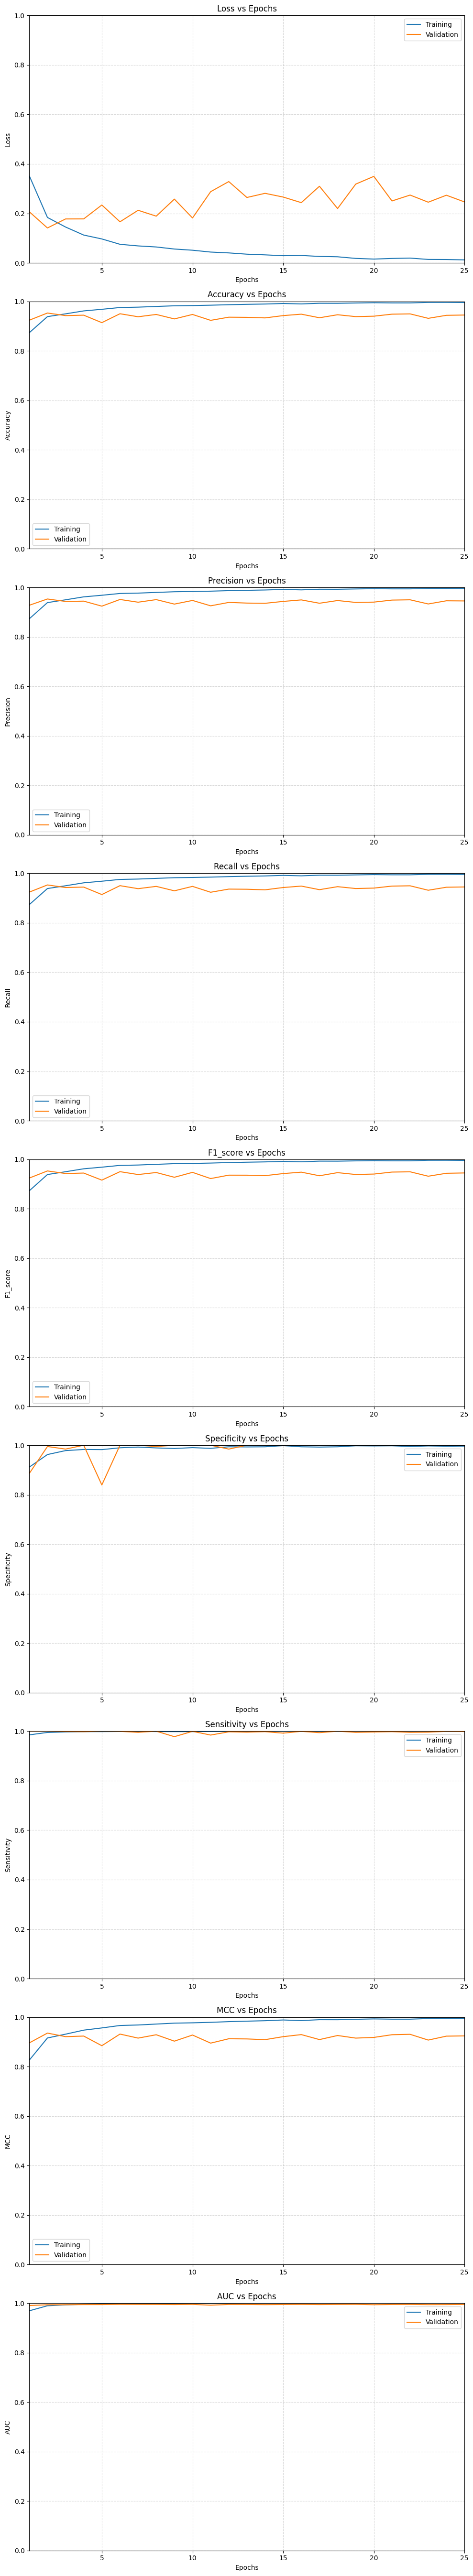

In [9]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [10]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 617/617 [00:22<00:00, 27.63it/s]

Metrics - loss: 0.2133, accuracy: 0.9493, precision: 0.9496, recall: 0.9493, f1_score: 0.9491, specificity: 1.0000, sensitivity: 0.9975, mcc: 0.9306, auc: 0.9950


In [ ]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get a list of subdirectories (class names) in the data directory
# Option 1: sort the list
# classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

# # Option 2: if using ImageFolder
classes = full_train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9806    1.0000    0.9902       556
              COVID     0.9750    0.9723    0.9737       723
       Lung_Opacity     0.9397    0.8943    0.9165      1202
             Normal     0.9309    0.9652    0.9477      2039
       Tuberculosis     1.0000    0.8929    0.9434       140
    Viral Pneumonia     0.9767    0.9368    0.9564       269

           accuracy                         0.9493      4929
          macro avg     0.9672    0.9436    0.9546      4929
       weighted avg     0.9496    0.9493    0.9491      4929

There were 250 errors in 4929 tests for an accuracy of  94.93


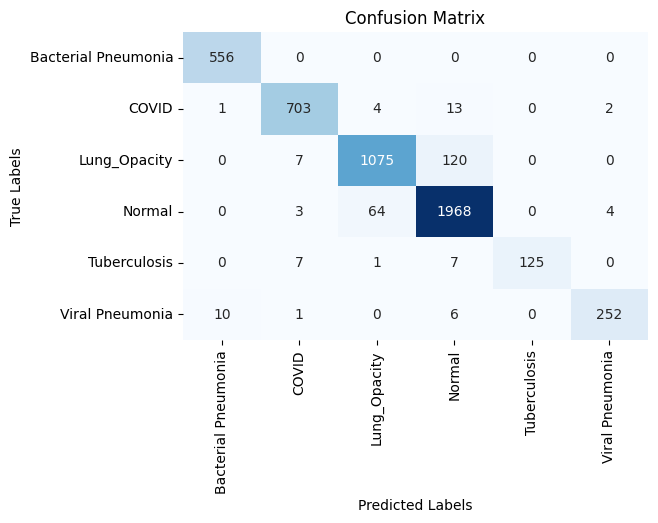

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()